# Assignment 3 by: Bharath Narayanan Venkatesh (S4033348)


# Task 1: User-based Collaborative Filtering


In [1]:
#Importing various libraries
import pandas as pd
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Loading the datasets
movies = pd.read_csv('C:/Users/Pro HP/ml-1m/movies.dat', sep='::', engine='python', names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')

In [3]:
ratings = pd.read_csv('C:/Users/Pro HP/ml-1m/ratings.dat', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [4]:
# Creating user-item matrix
user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')

In [5]:
# Computing user similarity using Cosine Similarity
user_item_matrix_filled = user_item_matrix.fillna(0)
user_similarity_cosine = cosine_similarity(user_item_matrix_filled)

In [6]:
# Predicting ratings using mean-centered approach with Cosine Similarity
def predict_ratings_mean_centered_cosine(user_id, user_similarity, matrix, k=10):
    similar_users = np.argsort(user_similarity[user_id-1])[-k-1:-1]
    user_mean = matrix.loc[user_id].mean()
    predicted_ratings = np.zeros(matrix.shape[1])
    
    for i in range(matrix.shape[1]):
        numerator = sum([(user_similarity[user_id-1, u] * (matrix.iloc[u, i] - matrix.iloc[u].mean())) for u in similar_users if not np.isnan(matrix.iloc[u, i])])
        denominator = sum([abs(user_similarity[user_id-1, u]) for u in similar_users if not np.isnan(matrix.iloc[u, i])])
        
        if denominator != 0:
            predicted_ratings[i] = user_mean + (numerator / denominator)
        else:
            predicted_ratings[i] = user_mean
    return predicted_ratings

# Randomly choosing a user
random_user = random.choice(user_item_matrix.index.tolist())
movies_rated_by_user = user_item_matrix.columns[user_item_matrix.loc[random_user].notna()].tolist()

In [7]:
# Displaing actual vs predicted ratings for the movies the user has rated
movie_positions_rated_by_user = [user_item_matrix.columns.get_loc(movie_id) for movie_id in movies_rated_by_user]
predicted_ratings_mean_centered_cosine = predict_ratings_mean_centered_cosine(random_user, user_similarity_cosine, user_item_matrix)
predicted_ratings_for_movies_rated_cosine = predicted_ratings_mean_centered_cosine[movie_positions_rated_by_user]

ratings_comparison_cosine = pd.DataFrame({
    'Movie Title': movies.set_index('MovieID').loc[movies_rated_by_user]['Title'].values,
    'Actual Rating': user_item_matrix.loc[random_user, movies_rated_by_user].values,
    'Predicted Rating (Cosine)': predicted_ratings_for_movies_rated_cosine
})
print(ratings_comparison_cosine)


                                     Movie Title  Actual Rating  \
0                              Abyss, The (1989)            4.0   
1         One Flew Over the Cuckoo's Nest (1975)            4.0   
2                     Alien: Resurrection (1997)            3.0   
3                                      Pi (1998)            3.0   
4                                      54 (1998)            2.0   
5              10 Things I Hate About You (1999)            3.0   
6   Austin Powers: The Spy Who Shagged Me (1999)            2.0   
7                            American Pie (1999)            3.0   
8                          Eyes Wide Shut (1999)            4.0   
9                       13th Warrior, The (1999)            2.0   
10                        American Beauty (1999)            5.0   
11                         Angela's Ashes (1999)            4.0   
12                             Titan A.E. (2000)            3.0   
13                            Chicken Run (2000)            4.

In [8]:
# Impact of different K values on RMSE
k_values = [5, 15, 20, 30, 40]
rmse_values_cosine = []

for k in k_values:
# Predict ratings for the specific user using a mean-centered cosine-based approach with 'k' nearest neighbors
    predicted_ratings_for_user = predict_ratings_mean_centered_cosine(random_user, user_similarity_cosine, user_item_matrix, k=k)
    predicted_ratings_for_movies_rated = predicted_ratings_for_user[movie_positions_rated_by_user]
    rmse_k = np.sqrt(mean_squared_error(user_item_matrix.loc[random_user, movies_rated_by_user].values, predicted_ratings_for_movies_rated))
# Appending the computed RMSE for the current 'k' value to the list 'rmse_values_cosine'    
    rmse_values_cosine.append(rmse_k)

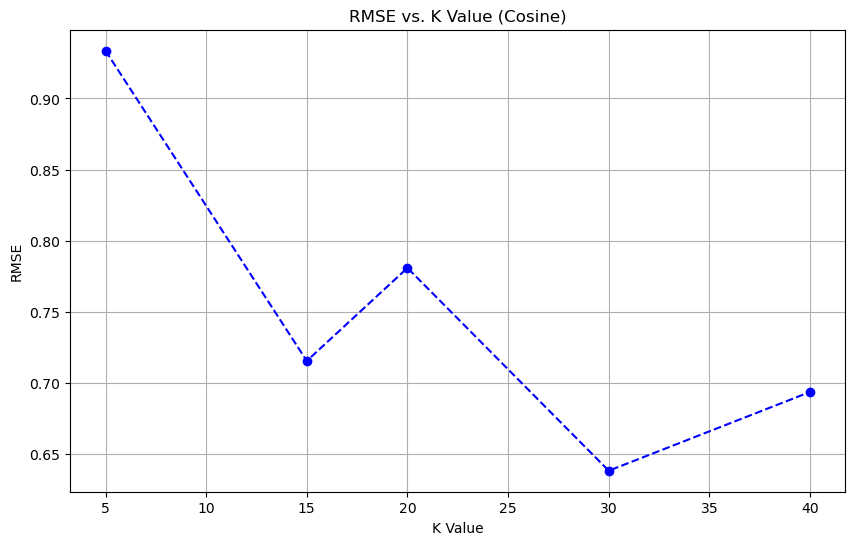

In [9]:
# Plot the RMSE values
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values_cosine, marker='o', linestyle='--', color='b')
plt.title('RMSE vs. K Value (Cosine)')
plt.xlabel('K Value')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Task 2: Item-based Filtering

In [10]:
ratings = pd.read_csv('C:/Users/Pro HP/ml-1m/ratings.dat', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [11]:
user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')

In [12]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

# Setting seed for reproducibility
np.random.seed(50)

# Selecting a random movie from the 'user_item_matrix' columns
random_movie = np.random.choice(user_item_matrix.columns)

# Printing randomly selected movie's ID
print(f"I've randomly selected the movie with MovieID: {random_movie}")

movie_title = movies[movies['MovieID'] == random_movie]['Title'].iloc[0]

# Printing the name of randomly selected movie
print(f"I've randomly selected the movie name: {movie_title}")

# Calculating item similarities using cosine similarity and Pearson correlation
item_similarity_cosine = cosine_similarity(user_item_matrix.T.fillna(0))
item_similarity_pearson = 1 - pairwise_distances(user_item_matrix.T.fillna(0), metric="correlation")

# Finding similar movies based on cosine similarity and Pearson correlation
similar_movies_cosine = np.argsort(item_similarity_cosine[random_movie - 1])[-11:-1]
similar_movies_pearson = np.argsort(item_similarity_pearson[random_movie - 1])[-11:-1]

# Predicting ratings for the selected movie using cosine similarity
predicted_ratings_movie_cosine = np.dot(item_similarity_cosine[random_movie - 1, similar_movies_cosine], user_item_matrix.T.iloc[similar_movies_cosine].fillna(0)) / np.sum(np.abs(item_similarity_cosine[random_movie - 1, similar_movies_cosine]), axis=0)
predicted_ratings_movie_cosine = np.clip(predicted_ratings_movie_cosine, 1, 5)

# Predicting ratings for the selected movie using Pearson correlation
predicted_ratings_movie_pearson = np.dot(item_similarity_pearson[random_movie - 1, similar_movies_pearson], user_item_matrix.T.iloc[similar_movies_pearson].fillna(0)) / np.sum(np.abs(item_similarity_pearson[random_movie - 1, similar_movies_pearson]), axis=0)
predicted_ratings_movie_pearson = np.clip(predicted_ratings_movie_pearson, 1, 5)

actual_ratings_movie = user_item_matrix[random_movie].dropna().values
users_rated_movie = user_item_matrix[random_movie].dropna().index

# Calculating RMSE for predicted ratings using cosine similarity and Pearson correlation
rmse_movie_cosine = np.sqrt(mean_squared_error(actual_ratings_movie, predicted_ratings_movie_cosine[users_rated_movie - 1]))
rmse_movie_pearson = np.sqrt(mean_squared_error(actual_ratings_movie, predicted_ratings_movie_pearson[users_rated_movie - 1]))

# Printing RMSE for cosine similarity and Pearson correlation
print(f"RMSE for cosine similarity: {rmse_movie_cosine:.3f}")
print(f"RMSE for Pearson correlation: {rmse_movie_pearson:.3f}")

ratings_data = {
    'UserID': users_rated_movie,
    'Actual Ratings': actual_ratings_movie,
    'Predicted Ratings (Cosine)': predicted_ratings_movie_cosine[users_rated_movie - 1],
    'Predicted Ratings (Pearson)': predicted_ratings_movie_pearson[users_rated_movie - 1]
}

predicted_ratings_df = pd.DataFrame(ratings_data)
print(predicted_ratings_df.head(10))

I've randomly selected the movie with MovieID: 1892
I've randomly selected the movie name: Perfect Murder, A (1998)
RMSE for cosine similarity: 2.385
RMSE for Pearson correlation: 2.386
   UserID  Actual Ratings  Predicted Ratings (Cosine)  \
0      15             4.0                    1.000000   
1      33             3.0                    1.000000   
2      48             3.0                    1.407862   
3      60             3.0                    1.000000   
4      82             4.0                    1.000000   
5      90             4.0                    1.000000   
6     123             3.0                    1.109604   
7     127             3.0                    1.000000   
8     133             4.0                    1.000000   
9     156             5.0                    1.000000   

   Predicted Ratings (Pearson)  
0                     1.000000  
1                     1.000000  
2                     1.400425  
3                     1.000000  
4                    

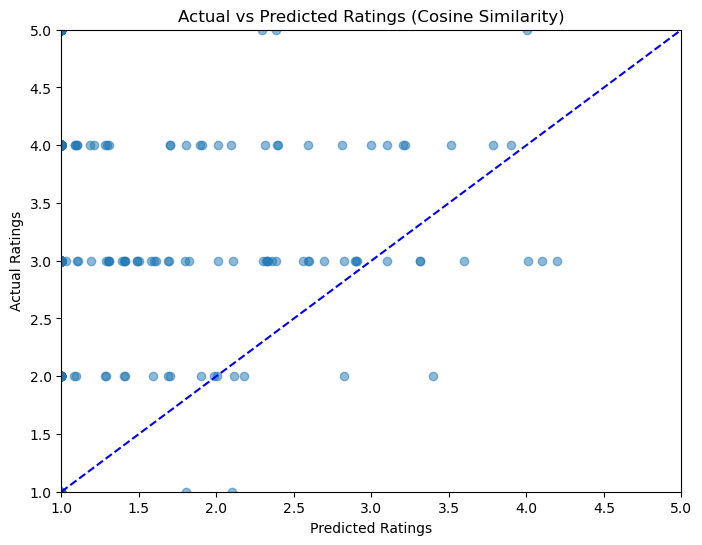

In [13]:
# Scatter plot for Cosine Similarity
plt.figure(figsize=(8, 6))
plt.scatter(predicted_ratings_movie_cosine[users_rated_movie - 1], actual_ratings_movie, alpha=0.5)
plt.title("Actual vs Predicted Ratings (Cosine Similarity)")
plt.xlabel("Predicted Ratings")
plt.ylabel("Actual Ratings")
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.plot([1, 5], [1, 5], linestyle='--', color='blue')  # Adding a diagonal line for reference
plt.show()

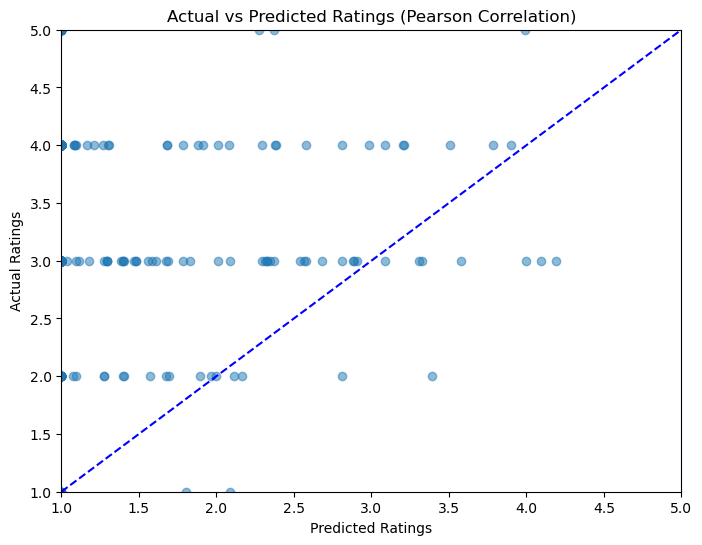

In [14]:
# Scatter plot for Pearson Correlation
plt.figure(figsize=(8, 6))
plt.scatter(predicted_ratings_movie_pearson[users_rated_movie - 1], actual_ratings_movie, alpha=0.5)
plt.title("Actual vs Predicted Ratings (Pearson Correlation)")
plt.xlabel("Predicted Ratings")
plt.ylabel("Actual Ratings")
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.plot([1, 5], [1, 5], linestyle='--', color='blue')  # Adding a diagonal line for reference
plt.show()

# Task 3: A Better Recommender System

In [15]:
from scipy.sparse.linalg import svds

# 1. Load the datasets
users = pd.read_csv("C:/Users/Pro HP/ml-1m/users.dat", sep="::", engine='python', header=None, names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

In [16]:
movies = pd.read_csv("C:/Users/Pro HP/ml-1m/movies.dat", sep="::", engine='python', encoding='ISO-8859-1', header=None, names=["MovieID", "Title", "Genres"])

In [17]:
ratings = pd.read_csv("C:/Users/Pro HP/ml-1m/ratings.dat", sep="::", engine='python', header=None, names=["UserID", "MovieID", "Rating", "Timestamp"])

In [18]:
# Preparing the user-item matrix
user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

# Decomposing the matrix using SVD from numpy
U, sigma, Vt = np.linalg.svd(user_item_matrix, full_matrices=False)

# Reconstructing the matrix to get predicted ratings using the full U, sigma, and Vt
predicted_ratings = np.dot(np.dot(U, np.diag(sigma)), Vt)
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)

# Function to get top N predicted movie recommendations for a given user
def get_predicted_recommendations(user_id, N=30):
    user_predicted_ratings = predicted_ratings_df.loc[user_id]
    recommended_movies = user_predicted_ratings.sort_values(ascending=False).index[:N].tolist()
    return recommended_movies

# Function to compute AP and NDCG for a given user's recommendations
def compute_AP_and_NDCG(user, recommended_movies):
    top_rated_movies = ratings[ratings['UserID'] == user].sort_values(by='Rating', ascending=False).head(30)['MovieID'].tolist()
    relevant_items = 0
    precision_sum = 0
    for i, movie in enumerate(recommended_movies):
        if movie in top_rated_movies:
            relevant_items += 1
            precision_sum += relevant_items / (i + 1)
    AP = precision_sum / min(len(top_rated_movies), len(recommended_movies))
    DCG = 0
    IDCG = sum([1 / np.log2(i + 2) for i in range(min(len(top_rated_movies), len(recommended_movies)))])
    for i, movie in enumerate(recommended_movies):
        if movie in top_rated_movies:
            DCG += 1 / np.log2(i + 2)
    NDCG = DCG / IDCG
    return AP, NDCG

In [19]:
# Selecting random users who have rated more than 100 movies each
active_users = ratings['UserID'].value_counts()
active_users_over_100 = active_users[active_users > 100].index.tolist()
random_selected_users = np.random.choice(active_users_over_100, 5, replace=False)

# Evaluate for each selected user
for user_id in random_selected_users:
    # Get top 30 predicted movie recommendations for the user
    recommended_movies = get_predicted_recommendations(user_id, N=30)
    
    # Compute AP and NDCG for the recommendations
    AP, NDCG = compute_AP_and_NDCG(user_id, recommended_movies)
    
    # Display evaluation metrics for each user
    print(f"User {user_id}: AP = {AP:.4f}, NDCG = {NDCG:.4f}")

User 5776: AP = 0.4894, NDCG = 0.6367
User 5840: AP = 0.4628, NDCG = 0.6618
User 1980: AP = 0.0640, NDCG = 0.2067
User 2638: AP = 0.3989, NDCG = 0.5812
User 4606: AP = 0.4664, NDCG = 0.6702


In [20]:
for user_id in random_selected_users:
    # Get top 30 predicted movie recommendations for the user
    recommended_movies = get_predicted_recommendations(user_id, N=30)
    
    # Compute AP and NDCG for the recommendations
    AP, NDCG = compute_AP_and_NDCG(user_id, recommended_movies)
    
    # Display evaluation metrics for each user
    print(f"User {user_id}: AP = {AP:.4f}, NDCG = {NDCG:.4f}")
    
    # Print top 30 predicted movie recommendations for the user
    print(f"Top 30 Predicted Recommendations for User {user_id}:")
    print(recommended_movies)

User 5776: AP = 0.4894, NDCG = 0.6367
Top 30 Predicted Recommendations for User 5776:
[2959, 6, 2571, 356, 2028, 2762, 1258, 858, 1196, 260, 527, 110, 1221, 780, 81, 2393, 1391, 1584, 349, 733, 2353, 246, 1590, 3555, 380, 2278, 1036, 2916, 2012, 457]
User 5840: AP = 0.4628, NDCG = 0.6618
Top 30 Predicted Recommendations for User 5840:
[261, 2396, 3114, 2804, 1, 356, 3252, 1073, 2302, 3809, 236, 2971, 3451, 1097, 73, 3512, 1947, 3545, 2565, 1207, 3450, 1299, 2739, 909, 2657, 3507, 318, 141, 539, 3873]
User 1980: AP = 0.0640, NDCG = 0.2067
Top 30 Predicted Recommendations for User 1980:
[2571, 377, 1198, 2028, 1376, 1610, 474, 2858, 2762, 3175, 339, 3418, 1270, 356, 1500, 3114, 2916, 150, 1721, 2641, 2640, 1219, 1206, 588, 539, 2959, 1282, 593, 3949, 2406]
User 2638: AP = 0.3989, NDCG = 0.5812
Top 30 Predicted Recommendations for User 2638:
[2571, 3578, 3114, 3753, 527, 1196, 2355, 1060, 47, 553, 2918, 2687, 110, 593, 3147, 1, 1198, 1199, 3525, 541, 1387, 260, 1136, 3361, 3421, 858, 2501

In [21]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Creating a user-movie matrix
user_movie_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

# Creating sparse matrix from the user-movie matrix
user_movie_matrix_sparse = csr_matrix(user_movie_matrix.values)

# Fit the KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_movie_matrix_sparse)

def knn_cf_recommendation(user_id, k=5):
    distances, indices = knn.kneighbors(user_movie_matrix.loc[user_id].values.reshape(1, -1), n_neighbors=k+1)
    similar_users = indices.squeeze().tolist()[1:]
    
    # Get top rated movies from similar users
    top_movies_from_similar_users = ratings[ratings['UserID'].isin(similar_users)].groupby('MovieID')['Rating'].mean().sort_values(ascending=False)
    
    # Excluding movies already rated by the user
    rated_movies = ratings[ratings['UserID'] == user_id]['MovieID'].tolist()
    recommendations = top_movies_from_similar_users[~top_movies_from_similar_users.index.isin(rated_movies)]
    return recommendations.index.tolist()[:30]

# Calculatinge the average rating for each movie
average_ratings = ratings.groupby('MovieID')['Rating'].mean().sort_values(ascending=False)

def get_movie_avg_recommendations(N=30):
    top_N_movies = average_ratings.head(N)
    return top_N_movies# Rest of the code for average rating recommendations remains the same

# Function to compute AP and NDCG for a given user's recommendations
def compute_AP_and_NDCG(user, recommended_movies):
    top_rated_movies = ratings[ratings['UserID'] == user].sort_values(by='Rating', ascending=False).head(30)['MovieID'].tolist()
    relevant_items = 0
    precision_sum = 0
    for i, movie in enumerate(recommended_movies):
        if movie in top_rated_movies:
            relevant_items += 1
            precision_sum += relevant_items / (i + 1)
    AP = precision_sum / min(len(top_rated_movies), len(recommended_movies))
    
    DCG = 0
    IDCG = sum([1 / np.log2(i + 2) for i in range(min(len(top_rated_movies), len(recommended_movies)))])
    for i, movie in enumerate(recommended_movies):
        if movie in top_rated_movies:
            DCG += 1 / np.log2(i + 2)
    NDCG = DCG / IDCG
    
    return AP, NDCG


# Selecting random users after all necessary computations
active_users = ratings['UserID'].value_counts()
active_users_over_100 = active_users[active_users > 100].index.tolist()
random_selected_users = np.random.choice(np.array(active_users_over_100), 5, replace=False)

# Computing AP and NDCG for each selected user using MovieAvg recommendations
movie_avg_metrics = {user: compute_AP_and_NDCG(user, get_movie_avg_recommendations().index) for user in random_selected_users}

# Computing AP and NDCG for each selected user using KNNCF recommendations
knncf_recommendations = {user: knn_cf_recommendation(user) for user in random_selected_users}
knncf_metrics = {user: compute_AP_and_NDCG(user, knncf_recommendations[user]) for user in random_selected_users}

print("MovieAvg Metrics:", movie_avg_metrics)
print("KNNCF Metrics:", knncf_metrics)


MovieAvg Metrics: {29: (0.011268059855521154, 0.07813511866312967), 1062: (0.00196078431372549, 0.026175882249243814), 754: (0.005416666666666667, 0.0515545066575401), 2100: (0.0017543859649122805, 0.025255271126572616), 1842: (0.00196078431372549, 0.026175882249243814)}
KNNCF Metrics: {29: (0.0, 0.0), 1062: (0.0, 0.0), 754: (0.0, 0.0), 2100: (0.0, 0.0), 1842: (0.0, 0.0)}


In [22]:
# Calculate the average rating for each movie
movie_avg_ratings = ratings.groupby('MovieID')['Rating'].mean()

# Sort the movies by their average ratings in descending order
sorted_movie_avg_ratings = movie_avg_ratings.sort_values(ascending=False)

# Get the top 30 movies based on average ratings
top_30_movie_avg = sorted_movie_avg_ratings.head(30).index.tolist()

# Store the recommended movies for each user in a dictionary
recommendations_movie_avg = {user: top_30_movie_avg for user in random_selected_users}

# Display the recommended movies for the selected users
recommended_movies_movieavg = movies[movies['MovieID'].isin(top_30_movie_avg)]
recommended_movies_movieavg

,MovieID,Title,Genres
49,50,"Usual Suspects, The (1995)",Crime|Thriller
52,53,Lamerica (1994),Drama
315,318,"Shawshank Redemption, The (1994)",Drama
435,439,Dangerous Game (1993),Drama
523,527,Schindler's List (1993),Drama|War
553,557,Mamma Roma (1962),Drama
574,578,"Hour of the Pig, The (1993)",Drama|Mystery
735,745,"Close Shave, A (1995)",Animation|Comedy|Thriller
777,787,"Gate of Heavenly Peace, The (1995)",Documentary
847,858,"Godfather, The (1972)",Action|Crime|Drama


In [23]:
movie_avg_recommendations = {user: get_movie_avg_recommendations() for user in random_selected_users}

## 2.2: KNNCF Recommendations
knncf_recommendations = {user: knn_cf_recommendation(user) for user in random_selected_users}

## 2.3: SVD Recommendations (Option1RecSys)

svd_recommendations = {user: get_predicted_recommendations(user) for user in random_selected_users}

# Step 3: Evaluating Recommendations

## 3.1: Computing metrics for MovieAvg Recommendations
movie_avg_metrics = {user: compute_AP_and_NDCG(user, movie_avg_recommendations[user]) for user in random_selected_users}

## 3.2: Computing metrics for KNNCF Recommendations
knncf_metrics = {user: compute_AP_and_NDCG(user, knncf_recommendations[user]) for user in random_selected_users}

## 3.3: Computing metrics for SVD Recommendations
svd_metrics = {user: compute_AP_and_NDCG(user, svd_recommendations[user]) for user in random_selected_users}

print("Randomly selected users:", random_selected_users)
print("MovieAvg Metrics:", movie_avg_metrics)
print("KNNCF Metrics:", knncf_metrics)
print("SVD Metrics:", svd_metrics)

Randomly selected users: [  29 1062  754 2100 1842]
MovieAvg Metrics: {29: (0.0, 0.0), 1062: (0.0, 0.0), 754: (0.0, 0.0), 2100: (0.0, 0.0), 1842: (0.0, 0.0)}
KNNCF Metrics: {29: (0.0, 0.0), 1062: (0.0, 0.0), 754: (0.0, 0.0), 2100: (0.0, 0.0), 1842: (0.0, 0.0)}
SVD Metrics: {29: (0.9333333333333333, 0.9557233482059448), 1062: (0.11187740037740038, 0.2896532020461434), 754: (0.43674888600080414, 0.6464433962548009), 2100: (0.36300137483253164, 0.5803158496266553), 1842: (0.06864258347016967, 0.24021312053913058)}


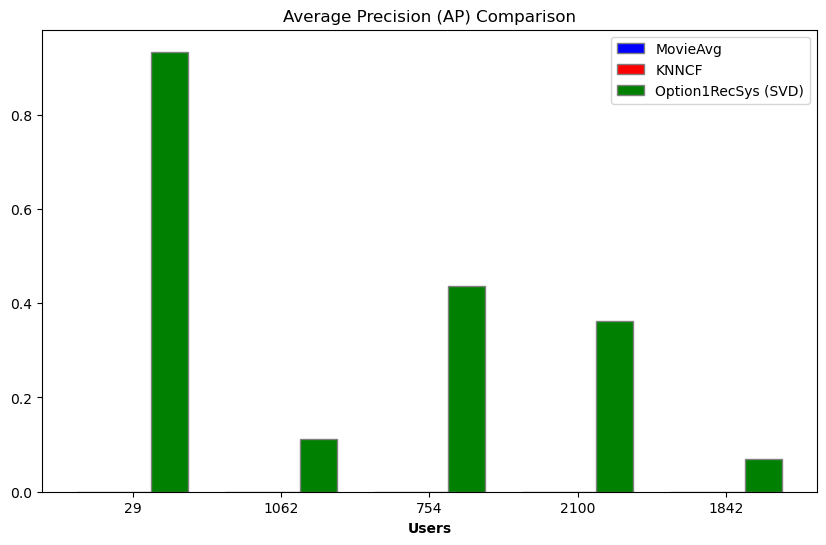

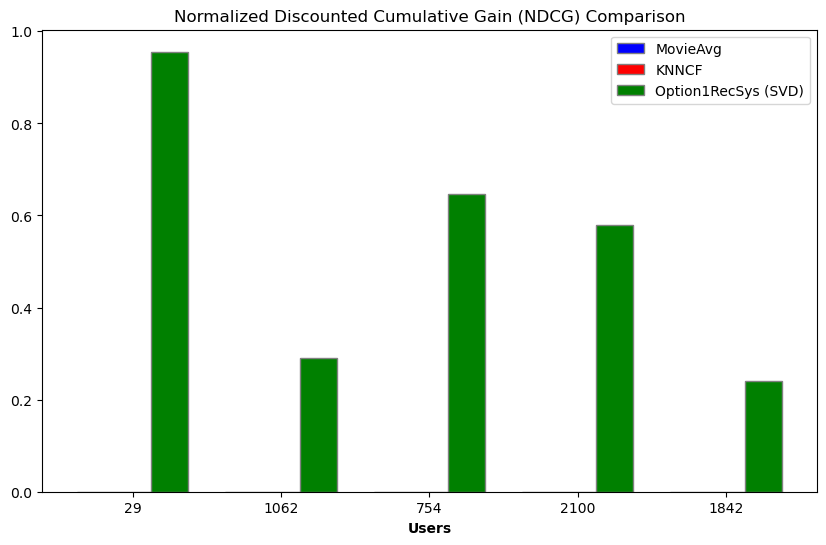

In [24]:
import matplotlib.pyplot as plt

# Extract AP and NDCG values for each recommendation method
movie_avg_ap = [movie_avg_metrics[user][0] for user in random_selected_users]
knncf_ap = [knncf_metrics[user][0] for user in random_selected_users]
svd_ap = [svd_metrics[user][0] for user in random_selected_users]

movie_avg_ndcg = [movie_avg_metrics[user][1] for user in random_selected_users]
knncf_ndcg = [knncf_metrics[user][1] for user in random_selected_users]
svd_ndcg = [svd_metrics[user][1] for user in random_selected_users]

# Setting the bar width and positions
bar_width = 0.25
r1 = np.arange(len(random_selected_users))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the bars
plt.figure(figsize=(10, 6))
plt.bar(r1, movie_avg_ap, color='b', width=bar_width, edgecolor='grey', label='MovieAvg')
plt.bar(r2, knncf_ap, color='r', width=bar_width, edgecolor='grey', label='KNNCF')
plt.bar(r3, svd_ap, color='g', width=bar_width, edgecolor='grey', label='Option1RecSys (SVD)')

# Title & Subtitle
plt.title('Average Precision (AP) Comparison')
plt.xlabel('Users', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(movie_avg_ap))], random_selected_users)

# Creating legend & Show graphic
plt.legend()
plt.show()

# Repeating for NDCG
plt.figure(figsize=(10, 6))
plt.bar(r1, movie_avg_ndcg, color='b', width=bar_width, edgecolor='grey', label='MovieAvg')
plt.bar(r2, knncf_ndcg, color='r', width=bar_width, edgecolor='grey', label='KNNCF')
plt.bar(r3, svd_ndcg, color='g', width=bar_width, edgecolor='grey', label='Option1RecSys (SVD)')

# Title & Subtitle
plt.title('Normalized Discounted Cumulative Gain (NDCG) Comparison')
plt.xlabel('Users', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(movie_avg_ndcg))], random_selected_users)

# Create legend & Show graphic
plt.legend()
plt.show()